In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt


In [2]:
class TrainDataset(Dataset):
    def __init__(self, train_file, transform=None):
        self.data = pd.read_csv(train_file)
        self.data = self.data.iloc[:,1:]
        self.transform = transform
        if transform is not None:
            self.data = self.transform(np.array(self.data))

    def __len__(self):
        return len(self.data[0])

    def __getitem__(self, ind):
        user_vector = self.data.data[0][ind]
        return user_vector



In [3]:
class TestDataset(Dataset):
    def __init__(self, test_file, transform=None):
        self.data = pd.read_csv(test_file)
        self.data = self.data.iloc[:,1:]
        self.transform = transform
        if transform is not None:
            self.data = self.transform(np.array(self.data))

    def __len__(self):
        return len(self.data[0])

    def __getitem__(self, ind):
        user_vector = self.data.data[0][ind]
        return user_vector


In [4]:
def prepare_train_validation_movielens_step1():
    rat = pd.read_csv('/content/ratings.csv')
    mov = pd.read_csv('/content/movies.csv')
    df_combined = pd.merge(rat, mov, on = 'movieId')
    print(rat.describe())
    ts = rat['timestamp'].quantile(0.98)
    train_ratings = pd.DataFrame(columns=['userId','movieId','rating'])
    validation_ratings = pd.DataFrame(columns=['userId','movieId','rating'])
    for i in range(len(rat)):
        if rat['timestamp'].iloc[i] <= ts:
            train_ratings = pd.concat([train_ratings,pd.DataFrame([{'userId':rat['userId'].iloc[i],'movieId':rat ['movieId'].iloc[i],'rating':rat['rating'].iloc[i]}])])
            validation_ratings = pd.concat([validation_ratings,pd.DataFrame([{'userId':rat['userId'].iloc[i],'movieId':rat['movieId'].iloc[i],'rating':rat['rating'].iloc[i]}])])
        else:
            validation_ratings = pd.concat([validation_ratings,pd.DataFrame([{'userId':rat['userId'].iloc[i],'movieId':rat['movieId'].iloc[i],'rating':rat['rating'].iloc[i]}])])
        if i%10000 == 0:
            print(i, "Completed")
    print(len(train_ratings))
    print(len(validation_ratings))
    # Remove users in validation set those are not present in Training Set
    train_users = train_ratings['userId'].unique()
    users_not_in_train_set = []

    for i in range(1,611):
        if i in train_users:
            continue
        else:
            users_not_in_train_set.append(i)

    for i in users_not_in_train_set:
        validation_ratings = validation_ratings[validation_ratings['userId']!=i]

    validation_ratings.reset_index(drop=True)

    print(len(train_ratings['movieId'].unique()))
    print(len(validation_ratings['movieId'].unique()))
    # Remove Movies that are not in the Train Set
    validation_movies = validation_ratings['movieId'].unique()
    train_movies = train_ratings['movieId'].unique()
    movies_not_in_train_set = []

    for i in validation_movies:
        if i in train_movies:
            continue
        else:
            movies_not_in_train_set.append(i)

    for i in movies_not_in_train_set:
        validation_ratings = validation_ratings[validation_ratings['movieId']!=i]

    validation_ratings.reset_index(drop=True)
    print('Train Users: ', train_ratings['userId'].nunique())
    print('Validation Users: ',validation_ratings['userId'].nunique())
    print('Train Movies: ',train_ratings['movieId'].nunique())
    print('Validation Movies: ',validation_ratings['movieId'].nunique())
    train_ratings.to_csv("/content/train_ratings.csv")
    validation_ratings.to_csv("/content/validation_ratings.csv")



In [5]:
def prepare_traintest_movielens_step2():
    tr_ratings = pd.read_csv('/content/train_ratings.csv')
    val_ratings = pd.read_csv('/content/validation_ratings.csv')
    train_dataset = tr_ratings.pivot_table(index = 'userId', columns = 'movieId', values = 'rating')
    train_dataset.fillna(0, inplace=True)
    print(train_dataset.head(10))
    test_dataset = val_ratings.pivot_table(index='userId', columns='movieId', values='rating')
    test_dataset.fillna(0, inplace=True)
    print(test_dataset.head(10))
    train_dataset.to_csv('/content/train.csv')
    test_dataset.to_csv('/content/test.csv')


In [6]:
def get_traintestloaders():
    transformations = transforms.Compose([transforms.ToTensor()])
    train_dat = TrainDataset('/content/train.csv', transformations)
    test_dat = TestDataset('/content/test.csv', transformations)
    train_loader = DataLoader(dataset=train_dat, batch_size = 128, shuffle=True, num_workers = 1)
    test_loader = DataLoader(dataset=test_dat, batch_size=128, shuffle=True, num_workers=1)
    return train_loader, test_loader


In [7]:
class MSELoss_with_Mask(nn.Module):
    def __init__(self):
        super(MSELoss_with_Mask,self).__init__()

    def forward(self,inputs, targets):
        # Masking into a vector of 1's and 0's.
        mask = (targets!=0)
        mask = mask.float()
        # Actual number of ratings.
        # Take max to avoid division by zero while calculating loss.

        number_ratings = torch.max(torch.sum(mask),torch.tensor(1.0))
        error = torch.sum(torch.mul(mask,torch.mul((targets-inputs),(targets-inputs))))
        loss = error.div(number_ratings)
        return loss


In [13]:
import torch.nn.functional as F
import torch.nn.init as init

class AutoEncoder(nn.Module):
    def __init__(self, encoder_layers_sizes, activation='ReLU'):
        super(AutoEncoder, self).__init__()

        # Set activation function
        if activation == 'ReLU':
            self.activation = nn.ReLU()
        elif activation == 'Sigmoid':
            self.activation = nn.Sigmoid()
        else:
            raise ValueError("Unsupported activation function")

        # Create the encoder layers
        self.encoder = nn.Sequential()
        for i in range(len(encoder_layers_sizes) - 1):
            self.encoder.add_module(f"encoder_layer_{i}",
                                    nn.Linear(encoder_layers_sizes[i], encoder_layers_sizes[i + 1]))
            self.encoder.add_module(f"activation_{i}", self.activation)

        # Create the decoder layers (reverse of encoder layers)
        self.decoder = nn.Sequential()
        for i in range(len(encoder_layers_sizes) - 1, 0, -1):
            self.decoder.add_module(f"decoder_layer_{i}",
                                    nn.Linear(encoder_layers_sizes[i], encoder_layers_sizes[i - 1]))
            self.decoder.add_module(f"activation_{i}", self.activation)

    def encode(self, x):
        # Forward pass through encoder
        x = x.type(torch.float32)
        return self.encoder(x)

    def decode(self, x):
        # Forward pass through decoder
        return self.decoder(x)

    def forward(self, x):
        # Perform encoding and decoding
        x=x.view(x.size(0),-1)
        encoded = self.encode(x)
        decoded = self.decode(encoded)
        return decoded



Epoch 1/40 | Train Loss: 11.1623 | Test Loss: 9.8680
Epoch 2/40 | Train Loss: 15.9701 | Test Loss: 10.1616
Epoch 3/40 | Train Loss: 11.7724 | Test Loss: 12.4269
Epoch 4/40 | Train Loss: 11.4916 | Test Loss: 8.2687
Epoch 5/40 | Train Loss: 7.9338 | Test Loss: 6.4214
Epoch 6/40 | Train Loss: 6.5354 | Test Loss: 5.1928
Epoch 7/40 | Train Loss: 5.4537 | Test Loss: 5.3454
Epoch 8/40 | Train Loss: 4.9950 | Test Loss: 4.7885
Epoch 9/40 | Train Loss: 4.3941 | Test Loss: 4.4087
Epoch 10/40 | Train Loss: 4.1858 | Test Loss: 4.1099
Epoch 11/40 | Train Loss: 3.8702 | Test Loss: 3.7080
Epoch 12/40 | Train Loss: 3.5280 | Test Loss: 3.6930
Epoch 13/40 | Train Loss: 3.4508 | Test Loss: 3.4530
Epoch 14/40 | Train Loss: 3.3854 | Test Loss: 3.1772
Epoch 15/40 | Train Loss: 3.2234 | Test Loss: 3.1191
Epoch 16/40 | Train Loss: 3.1068 | Test Loss: 3.0703
Epoch 17/40 | Train Loss: 3.0242 | Test Loss: 2.9097
Epoch 18/40 | Train Loss: 2.8880 | Test Loss: 2.8526
Epoch 19/40 | Train Loss: 2.8520 | Test Loss: 2.7

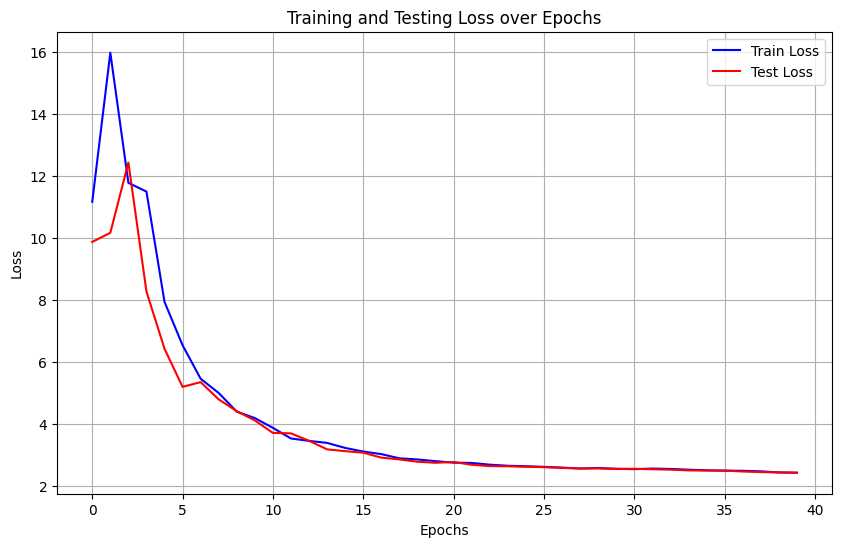

Recommended movies for user 0: [ 91978   1411   5872   7657 100556]


In [15]:
import torch.optim as optim
import matplotlib.pyplot as plt

def train(model, criterion, optimizer, train_dl, test_dl, num_epochs=50):
    model.train()  # Set model to training mode

    # Initialize lists to store the loss values during training and testing
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        epoch_train_loss = 0.0
        for i, data in enumerate(train_dl, 0):
            inputs = data
            targets = data #

            optimizer.zero_grad()  # Zero the gradients before backward pass
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Optimize the model's weights

            epoch_train_loss += loss.item()

        # Average training loss for the epoch
        epoch_train_loss /= len(train_dl)
        train_losses.append(epoch_train_loss)

        # Testing phase (no gradient calculation)
        model.eval()  # Set model to evaluation mode


        with torch.no_grad():  # Disable gradient calculation
            epoch_test_loss = 0.0
            for data in test_dl:
                inputs = data
                targets = data

                outputs = model(inputs)
                loss = criterion(outputs, targets)
                epoch_test_loss += loss.item()

            epoch_test_loss /= len(test_dl)
            test_losses.append(epoch_test_loss)

        # Print epoch results
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_train_loss:.4f} | Test Loss: {epoch_test_loss:.4f}")

    # Return loss histories for plotting or analysis
    return train_losses, test_losses

# Recommend movies for a user based on their predicted ratings
def recommend_movies_for_user(user_id, model, train_data, num_recommendations=5):
    model.eval()  # Set the model to evaluation mode

    # Get all movieIds in the training data
    all_movie_ids = train_data['movieId'].unique()

    # Create a dictionary mapping movieId to index
    movie_id_to_index = {movie_id: index for index, movie_id in enumerate(all_movie_ids)}

    # Get the movies rated by the user
    user_rated_movies = train_data.loc[train_data['userId'] == user_id + 1, 'movieId'].values

    # Create the input tensor for the model
    # (all movies rated 0 initially, then filled with user ratings)
    input_tensor = torch.zeros(len(all_movie_ids), dtype=torch.float32)

    # Set rated movies to 1 in the input tensor (binary rating)
    for movie_id in user_rated_movies:
        input_tensor[movie_id_to_index[movie_id]] = 1  # Or use actual ratings if needed

    # Convert the input to a tensor and add an extra dimension for batch size
    input_tensor = input_tensor.unsqueeze(0)

    # Get the predicted ratings for all movies
    with torch.no_grad():
        predictions = model(input_tensor).squeeze().cpu().numpy()

    # Mask out the already rated movies (set them to a very low value)
    rated_mask = input_tensor.squeeze().cpu().numpy() != 0
    predictions[rated_mask] = -np.inf  # Set rated movies to -inf

    # Get the top N recommendations based on the predicted ratings
    recommended_movie_indices = np.argsort(predictions)[::-1][:num_recommendations]

    # Map the movie indices back to movie IDs
    recommended_movie_ids = all_movie_ids[recommended_movie_indices]

    return recommended_movie_ids

def recommend_for_all_users(model, train_data, num_recommendations=5):
    all_user_ids = train_data['userId'].unique()

    recommendations = {}
    for user_id in all_user_ids:
        recommended_movies = recommend_movies_for_user(user_id - 1, model, train_data, num_recommendations)  # user_id - 1 to match indices
        recommendations[user_id] = recommended_movies

    return recommendations


train_ratings = pd.read_csv('/content/train_ratings.csv')

def main():
    #prepare_train_validation_movielens_step1()
    #prepare_traintest_movielens_step2()

    train_loader, test_loader = get_traintestloaders()
    encoder_layers_sizes = [9559, 512, 512, 1024]
    model = AutoEncoder(encoder_layers_sizes, activation = 'ReLU')
    criterion = MSELoss_with_Mask()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    # Train the model and get training/testing loss
    train_losses, test_losses = train(model, criterion, optimizer, train_loader, test_loader, num_epochs=40)

    # Store the returned losses into 'out' (this is optional, for debugging or further use)
    out = (train_losses, test_losses)

    model.eval()
    correct = 0
    total = 0
    threshold = 0.01  # Adjust threshold as needed

    with torch.no_grad():
        for data in test_loader:
            inputs = data
            targets = data

            outputs = model(inputs)
            reconstruction_error = torch.abs(outputs - targets)

            correct += torch.sum(reconstruction_error < threshold).item()
            total += targets.numel()

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Train Loss: {train_losses[-1]:.4f}")  # Print the last train loss
    print(f"Test Loss: {test_losses[-1]:.4f}")  # Print the last test loss

    all_recommendations = recommend_for_all_users(model, train_data=train_ratings, num_recommendations=5)
    # Print recommendations for each user
    for user_id, recommended_movies in all_recommendations.items():
          print(f"Recommended movies for user {user_id}: {recommended_movies}")


    # Plotting the loss function for both training and validation (testing)
    plt.figure(figsize=(10, 6))
    plt.plot(out[0], label='Train Loss', color='blue')
    plt.plot(out[1], label='Test Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()
    # After training, recommend movies for a specific user (e.g., user 0)
    user_id = 0  # Example: Recommending for user 0
    recommended_movies = recommend_movies_for_user(user_id, model, train_data=train_ratings, num_recommendations=5)  # [CHANGED]
    print(f"Recommended movies for user {user_id}: {recommended_movies}")


if __name__ == '__main__':
    main()




In [16]:
import sys
import numpy as np

def main():
    UP_Rating = np.array([[0,2,0,0,3,0,0,0,0,0],
    [4,0,0,0,3,0,0,0,5,0],
    [0,0,0,0,0,3,0,0,0,0],
    [0,5,0,0,0,0,0,0,0,2],
    [0,0,0,0,0,0,0,5,0,0],
    [5,2,0,0,0,0,0,0,0,0],
    [0,0,0,3,0,0,4,0,5,2],
    [0,3,0,4,0,0,0,0,0,0],
    [0,0,4,0,0,2,0,0,0,1],
    [0,0,0,0,5,0,3,0,2,0],
    [1,5,0,0,0,4,0,0,0,0],
    [0,0,4,0,5,0,0,3,0,2],
    [1,0,0,4,0,0,0,1,0,0],
    [0,5,0,3,0,0,0,0,4,0],
    [4,0,0,0,4,0,0,0,0,0],
    [0,0,0,5,0,2,0,0,0,0],
    # The problematic '2' was removed to make the array dimensions consistent
    [0,3,0,0,0,0,4,0,0,0],
    [3,3,0,0,0,0,0,0,0,5]]) # Include the last row properly
    u, s, vh = np.linalg.svd(UP_Rating, full_matrices=False)
    print(u.shape)
    print(s.shape)
    print(vh.shape)
    num_components = 3
    low_rank_reconstruction = u[:, :num_components] @ np.diag(s[:num_components]) @ vh[:num_components, :]
    print('---------reconstructed user-product rating matrix')
    print(np.round(low_rank_reconstruction))

    # Return a non-zero value to avoid sys.exit(0)
    return 1 # Or any other non-zero value that indicates successful execution


if __name__ == "__main__":
    # Remove sys.exit or change to a non-zero value
    main()  # Just call main() without sys.exit

(18, 10)
(10,)
(10, 10)
---------reconstructed user-product rating matrix
[[ 1.  1.  1. -0.  2.  0.  0.  0.  1.  1.]
 [ 2.  0.  1.  1.  4. -0.  2.  1.  3.  1.]
 [ 0.  1. -0.  0. -0.  0. -0. -0. -0.  0.]
 [ 1.  4.  0.  1. -0.  1. -0. -0. -0.  1.]
 [ 0. -0.  0. -0.  1. -0.  0.  0.  0.  0.]
 [ 2.  3.  1. -0.  1.  1. -0.  0. -0.  1.]
 [-0.  0. -0.  4.  1. -0.  3.  0.  4.  0.]
 [ 0.  3. -0.  2. -1.  1.  1. -0.  1.  1.]
 [ 1.  1.  0. -0.  1.  0. -0.  0. -0.  0.]
 [ 1. -1.  1.  1.  4. -0.  1.  1.  3.  1.]
 [ 2.  5.  0.  1. -0.  1. -0. -0. -0.  1.]
 [ 2. -0.  1. -1.  4. -0.  0.  1.  1.  1.]
 [-0.  1. -0.  2. -0.  0.  1. -0.  2.  0.]
 [ 1.  4. -0.  4. -0.  1.  1. -0.  3.  1.]
 [ 2.  0.  1. -1.  4. -0.  0.  1.  1.  1.]
 [-1.  1. -0.  3. -1.  0.  1. -0.  2. -0.]
 [ 1.  2. -0.  1.  0.  1.  0. -0.  1.  1.]
 [ 2.  4.  1. -0.  1.  1. -0.  0. -0.  2.]]
